In [1]:
import pickle

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import os
import numpy as np
import json
import importlib
from pathlib import Path
import requests
from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer
from tensor2tensor.data_generators import text_encoder
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import umap
import tempun

from datetime import datetime, timedelta

2025-12-19 23:45:23.416483: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 23:45:23.453603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jupyter-vojta/notebooks/labyrinth/venv_torch_nlp/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:

outdir = Path("../data/large_files/emlap_ruland_instances/")

hours = 50
cutoff = datetime.now() - timedelta(hours=hours)

files = []
for p in outdir.rglob("*"):          # use .glob("*") if you only want top-level
    if not p.is_file():
        continue
    mtime = datetime.fromtimestamp(p.stat().st_mtime)
    if mtime >= cutoff:
        files.append((p, mtime, p.stat().st_size))

# newest first
files.sort(key=lambda x: x[1], reverse=True)

print(f"Files modified in the last {hours} hours: {len(files)}")
for p, mtime, size in files[:50]:   # cap print if there are many
    print(f"{mtime:%Y-%m-%d %H:%M:%S}  {size/1e6:8.2f} MB  {p}")

Files modified in the last 50 hours: 2349
2025-12-19 19:49:25      0.00 MB  ../data/large_files/emlap_ruland_instances/.tmp_kwic_9d46f740dc8f46d6accd551910f1c2cb/part_000000001_000010000.parquet
2025-12-19 19:49:12      3.00 MB  ../data/large_files/emlap_ruland_instances/sanguinea.parquet
2025-12-19 19:48:48      0.01 MB  ../data/large_files/emlap_ruland_instances/sanguifuca.parquet
2025-12-19 19:48:33      0.12 MB  ../data/large_files/emlap_ruland_instances/sandix.parquet
2025-12-19 19:48:11      0.01 MB  ../data/large_files/emlap_ruland_instances/sanderichi.parquet
2025-12-19 19:47:57      0.49 MB  ../data/large_files/emlap_ruland_instances/sandaracha.parquet
2025-12-19 19:47:35      0.02 MB  ../data/large_files/emlap_ruland_instances/sandarach.parquet
2025-12-19 19:47:19      0.58 MB  ../data/large_files/emlap_ruland_instances/sandaraca.parquet
2025-12-19 19:46:57      0.20 MB  ../data/large_files/emlap_ruland_instances/sanc.parquet
2025-12-19 19:46:34      0.73 MB  ../data/large_fi

In [23]:
api_url = "https://ccs-lab.zcu.cz/grela-api/api/query"
query = "SELECT * FROM works"
works_df = pd.read_parquet(requests.post(api_url, json={"query": query}).json()["download_url"])

import json
import pandas as pd

def to_dict(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)   # -> dict
        except json.JSONDecodeError:
            return {}
    return {}

works_df["noscemus_discipline"] = (
    works_df["subcorpus_specific_metadata"]
      .map(to_dict)
      .map(lambda d: d.get("noscemus_discipline"))
)

noscemus_alchemy_ids = works_df[works_df["noscemus_discipline"].str.contains("Alchem", na=False)]["grela_id"]


In [168]:
noscemus_alchemy_ids.to_pickle("../data/noscemus_alchemy_ids.pickle")

In [161]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [162]:
base_path = "/srv/models/latin-bert"

# Initialize the tokenizer with the vocab.txt file and the encoder
vocab_file_path = "/srv/models/latin-bert/vocab.txt" # "/Users/vojtechkase/Projects/latin-bert/models/latin_bert/vocab.txt"  # Update this path
subword_tokenizer_path = "/srv/models/latin-bert/latin.subword.encoder"
# Update this path
encoder = text_encoder.SubwordTextEncoder(subword_tokenizer_path)

spec = importlib.util.spec_from_file_location("latin_tokenizer", os.path.join(base_path, "latin_tokenizer.py"))
latin_tokenizer = importlib.util.module_from_spec(spec)
loader = importlib.util.LazyLoader(spec.loader)
spec.loader.exec_module(latin_tokenizer)

LatinTokenizer = latin_tokenizer.LatinTokenizer

tokenizer_labert = LatinTokenizer(vocab_file_path, encoder)
# model_labert = AutoModel.from_pretrained(base_path)

model_labert_wsd = AutoModel.from_pretrained(
    "../../labyrinth/data/models/latin-bert-wic-ft",
    output_hidden_states=True,
    output_attentions=False
)

In [4]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [ ]:
# print(list(lexeme_df.loc[lexeme_df["target_canonical"]=="mercurius metallorum"]["sense_def_all"].iloc[0]))

In [ ]:
#lexeme_df["def_embeddings"] = lexeme_df.apply(lambda row: model.encode([row["target_canonical"] + ": " + str(sense_def) for sense_def in row["sense_def_all"]]), axis=1)

In [ ]:
#emb_dir = "../data/large_files/emlap_hits_embs"
#os.makedirs(emb_dir, exist_ok=True)

In [ ]:
#dir = "../data/large_files/emlap_ruland_instances"
#fname = "mercurius_metallorum.parquet"
#instances = pd.read_parquet(os.path.join(dir, fname)).to_dict("records")

In [192]:
outdir = Path("../data/large_files/emlap_ruland_instances/")

def read_hits(fname):
    try:
        path = os.path.join(outdir, fname)
        instances = pd.read_parquet(path).to_dict("records")
    except:
        instances = []
    return instances

In [193]:
instances_list = read_hits("aurum.parquet")
instances = pd.DataFrame(instances_list)
len(instances)

69768

In [194]:
instances.sample(10, random_state=42)

,target_phrase,target_from,matched_by,target_lemmata,target_token_ids,target_kwic_idx,target_sent_idx,grela_id,target_sentence_id,start_sentence_id,end_sentence_id,kwic_text,kwic_tokens,target_sentence_text,target_sentence_tokens,author,title,not_before,not_after
36706,[aurum],canonical,lemma,[aurum],[128602579],[10],[9],cc_12172,cc_12172_1614,cc_12172_1613,cc_12172_1615,: quaedam quia in partes tenuissimas diuidi po...,"[{'token_id': 128602569, 'token_text': ':', 'l...",quaedam quia in partes tenuissimas diuidi poss...,"[{'token_id': 128602570, 'token_text': 'quaeda...","Cardanus, Hieronymus",De subtilitate,1501.0,1576.0
18473,[auro],canonical,lemma,[aurum],[28233615],[10],[14],cc_14382,cc_14382_3718,cc_14382_3718,cc_14382_3719,nostro ad referendam largitati eius sedulam ma...,"[{'token_id': 28233605, 'token_text': 'nostro'...",Praeterea domino et principi nostro ad referen...,"[{'token_id': 28233601, 'token_text': 'Praeter...",Quintus Aurelius Symmachus,Epistulae,340.0,402.0
4894,[auri],canonical,lemma,[aurum],[390290529],[10],[1],noscemus_928888,noscemus_928888_11441,noscemus_928888_11439,noscemus_928888_11442,coactest in Maioricam renauigare . Armada illa...,"[{'token_id': 390290519, 'token_text': 'coacte...",Milionibus auri constiterat .,"[{'token_id': 390290528, 'token_text': 'Milion...","Candidus, Pantaleon",Tabulae chronologicae continentes seriem annor...,1597.0,1597.0
36185,[auri],canonical,lemma,[aurum],[259432467],[10],[14],emlap_100100,emlap_100100_3660,emlap_100100_3660,emlap_100100_3662,"ut dubia non tollit , ita nil arguit contra ma...","[{'token_id': 259432457, 'token_text': 'ut', '...","Inprimis hoc dubium , ut dubia non tollit , it...","[{'token_id': 259432453, 'token_text': 'Inprim...","Van Helmont, Jan Baptist",Ortus medicinae,1648.0,1648.0
19153,[auro],canonical,lemma,[aurum],[383108315],[10],[18],noscemus_756856,noscemus_756856_32366,noscemus_756856_32366,noscemus_756856_32367,"uicenos den tes elephantorum grandes , tertio ...","[{'token_id': 383108305, 'token_text': 'uiceno...","Herodotus prodit , Aethiopas tributi uice regi...","[{'token_id': 383108297, 'token_text': 'Herodo...","Gessner, Conrad",Historia animalium,1551.0,1558.0
6650,[auro],canonical,lemma,[aurum],[160252824],[10],[4],cc_10379,cc_10379_480,cc_10379_479,cc_10379_482,vel a rotunditate id est perfectione In monili...,"[{'token_id': 160252814, 'token_text': 'vel', ...",In monilibus gemmae in auro ponuntur,"[{'token_id': 160252820, 'token_text': 'In', '...",Robertus de Tumbalena,Commentaria in Cantica canticorum,1094.0,1094.0
41479,[aurum],canonical,lemma,[aurum],[8848958],[10],[1],cc_11798,cc_11798_91,cc_11798_90,cc_11798_91,"mei tenuitatem fortasse nescio , ideo semper t...","[{'token_id': 8848948, 'token_text': 'mei', 'l...","Qui aurum non habeo , quod possum facio , in d...","[{'token_id': 8848957, 'token_text': 'Qui', 'l...",Auctor incertus,De diversis ordinibus Ecclesiae,NaN,NaN
46594,[Auro],canonical,lemma,[aurum],[329872909],[10],[3],noscemus_597799,noscemus_597799_57014,noscemus_597799_57012,noscemus_597799_57015,gemmae Apocalypsis rerueius . spondeat chrysol...,"[{'token_id': 329872899, 'token_text': 'gemmae...","Respondeo chrysolithum X. Auro inclusus , & ge...","[{'token_id': 329872906, 'token_text': 'Respon...","Cesi, Bernardo",Mineralogia sive naturalis philosophiae thesau...,1636.0,1636.0
6513,[auri],canonical,lemma,[aurum],[322791012],[10],[0],noscemus_739101,noscemus_739101_5724,noscemus_739101_5721,noscemus_739101_5726,. Acontias . 243 . Ada fl . 73 . auri est fera...,"[{'token_id': 322791002, 'token_text': '.', 'l...",auri est ferax . 346 .,"[{'token_id': 322791012, 'token_text': 'auri',...","Wagner, Johann Jacob",Historia naturalis Helvetiae curiosa in VII se...,1680.0,1680.0
2189,[aurum],canonical,lemma,[aurum],[255601514],[10],[2],emlap_100094,emlap_100094_2815,emlap_100094_2814,emlap_100094_2816,", quod alias Philosophorum lapis facere queat ...","[{'token_id': 255601504, 'token_text': ',', 'l...",Solum ( aurum ) omni

In [195]:
import embedding_helpers
importlib.reload(embedding_helpers)
from embedding_helpers import *

In [196]:
sample_instance = instances.iloc[0]

In [197]:
# compute embedding
result = embedding_helpers.embed_emlap_instance(
    instance=sample_instance,
    tokenizer=tokenizer_labert,
    model=model_labert_wsd,
    device="cuda",                # or "cpu"
    layer_idx=11,
    piece_pooling="mean",
    context_lemmatized=True,
    target_lemmatized=False,
    context_pos_filtered=True,
)

In [198]:
result["target_tokens"]

[{'token_id': 127750416,
  'token_text': 'auro',
  'lemma': 'aurum',
  'pos': 'NOUN',
  'ref': '{}',
  'sentence_id': 'cc_17103_19820',
  'char_start': 9,
  'char_end': 13}]

In [199]:
result["embedding"]

array([-9.35036764e-02,  9.95930731e-01, -4.24069986e-02,  9.35123503e-01,
        4.59720910e-01, -8.47565293e-01, -1.73112655e+00, -4.54926193e-01,
        2.10860789e-01,  3.40749264e-01,  3.07116993e-02, -3.80359367e-02,
       -2.42135301e-01,  9.96433318e-01,  1.90429926e-01,  8.49506140e-01,
       -1.35844779e+00, -7.25300729e-01,  2.26079807e-01, -3.98047745e-01,
       -8.72304499e-01,  1.55665213e-02, -2.80719966e-01,  1.59945145e-01,
       -4.65146124e-01, -7.72628009e-01, -4.22277570e-01,  1.05353701e+00,
        2.37428039e-01, -5.43941677e-01, -1.18954861e+00,  3.74321342e-01,
       -7.56041706e-02,  2.84195513e-01, -4.56939489e-01,  8.21134567e-01,
        4.57023174e-01, -7.58934438e-01,  1.23650992e+00, -8.47757041e-01,
       -9.93166305e-03,  5.05750716e-01,  3.79565209e-01,  5.06293237e-01,
       -4.27090824e-02, -3.34706098e-01, -1.41392559e-01, -5.80011666e-01,
       -2.99298257e-01, -6.26408234e-02,  8.61580551e-01,  8.80192637e-01,
       -8.15429911e-03,  

In [200]:
#def_embeddings = np.stack(lexeme_df[lexeme_df["target_canonical"]=="lapis philosophorum"]["def_embeddings"])[0]

In [201]:
instances["grela_source"] = instances["grela_id"].apply(lambda x: x.partition("_")[0])
instances = instances[instances["grela_source"]!="vulgate"]


In [202]:
palette = {"cc": "orange",
           "noscemus_rest" : "green",
           "noscemus_alchymia" : "blue",
           "emlap" : "red"
}

def get_subset(row):
    if row["grela_source"]=="noscemus":
        if row["grela_id"] in noscemus_alchemy_ids.tolist():
            return "noscemus_alchymia"
        else:
            return "noscemus_rest"
    else:
        return row["grela_source"]
instances["subsets"] = instances.apply(lambda row: get_subset(row), axis=1)

In [203]:
instances_full_sizes_dict = instances.value_counts("subsets").to_dict()
instances_full_sizes_dict

{'cc': 37216,
 'noscemus_rest': 14074,
 'emlap': 11585,
 'noscemus_alchymia': 6577}

In [224]:
# up to 100 per subset (keeps all rows for smaller subsets)
instances = (
    instances
    .groupby("subsets", group_keys=False)
    .apply(lambda g: g.sample(n=min(100, len(g)), random_state=42))
    .reset_index(drop=True)
)

instances_samples_sizes_dict = instances["subsets"].value_counts().to_dict()
instances_samples_sizes_dict

/tmp/ipykernel_292755/723579689.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



{'cc': 100, 'emlap': 100, 'noscemus_alchymia': 100, 'noscemus_rest': 100}

In [231]:
import numpy as np
import pandas as pd

def avg_cosine_matrix_random_pairs(
    instances,
    subset_col="subsets",
    emb_col="embedding",
    order=None,
    n_pairs=100,
    random_state=42,
    kind="distance",   # "distance" (1-cos) or "similarity" (cos)
):
    if kind not in {"distance", "similarity"}:
        raise ValueError("kind must be 'distance' or 'similarity'")

    rng = np.random.default_rng(random_state)

    if order is None:
        order = list(pd.Index(instances[subset_col].dropna().unique()).sort_values())

    # collect normalized embedding matrices per subset
    mats = {}
    for s in order:
        X = np.vstack(
            instances.loc[instances[subset_col] == s, emb_col]
            .apply(lambda v: np.asarray(v, dtype=np.float32))
            .to_numpy()
        )
        X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)  # L2 normalize
        mats[s] = X

    out = pd.DataFrame(index=order, columns=order, dtype=float)

    for i, a in enumerate(order):
        Xa = mats[a]
        na = Xa.shape[0]

        for j, b in enumerate(order):
            if j < i:
                continue

            Xb = mats[b]
            nb = Xb.shape[0]

            if na == 0 or nb == 0:
                mean_sim = np.nan

            elif a != b:
                ia = rng.integers(0, na, size=n_pairs)
                ib = rng.integers(0, nb, size=n_pairs)
                sims = np.einsum("ij,ij->i", Xa[ia], Xb[ib])  # cosine similarity
                mean_sim = float(sims.mean())

            else:
                # within-subset: pair two *different* items each time
                if na < 2:
                    mean_sim = np.nan
                else:
                    ia = rng.integers(0, na, size=n_pairs)
                    ib = rng.integers(0, na, size=n_pairs)
                    same = (ia == ib)
                    while same.any():
                        ib[same] = rng.integers(0, na, size=int(same.sum()))
                        same = (ia == ib)
                    sims = np.einsum("ij,ij->i", Xa[ia], Xa[ib])
                    mean_sim = float(sims.mean())

            val = (1.0 - mean_sim) if kind == "distance" else mean_sim
            out.loc[a, b] = val
            out.loc[b, a] = val  # symmetry

    return out

In [233]:
D = avg_cosine_matrix_random_pairs(instances_sample, order=["emlap","noscemus_alchymia","noscemus_rest","cc"],
                                   n_pairs=100, kind="distance")
D

,emlap,noscemus_alchymia,noscemus_rest,cc
emlap,0.376419,0.397894,0.406037,0.431929
noscemus_alchymia,0.397894,0.382494,0.393984,0.449913
noscemus_rest,0.406037,0.393984,0.390438,0.431237
cc,0.431929,0.449913,0.431237,0.422359


In [234]:
S = avg_cosine_matrix_random_pairs(instances_sample, order=["emlap","noscemus_alchymia","noscemus_rest","cc"],
                                   n_pairs=100, kind="similarity")
S

,emlap,noscemus_alchymia,noscemus_rest,cc
emlap,0.623581,0.602106,0.593963,0.568071
noscemus_alchymia,0.602106,0.617506,0.606016,0.550087
noscemus_rest,0.593963,0.606016,0.609562,0.568763
cc,0.568071,0.550087,0.568763,0.577641


In [205]:
instances["date_random"] = [
    (d[0] if isinstance(d, (list, tuple, np.ndarray)) else d)
    for d in instances.apply(
        lambda row: tempun.model_date(row["not_before"], row["not_after"]),
        axis=1
    )
]

In [206]:
instances

,target_phrase,target_from,matched_by,target_lemmata,target_token_ids,target_kwic_idx,target_sent_idx,grela_id,target_sentence_id,start_sentence_id,...,kwic_tokens,target_sentence_text,target_sentence_tokens,author,title,not_before,not_after,grela_source,subsets,date_random
0,[auro],canonical,lemma,[aurum],[207872643],[10],[25],cc_11632,cc_11632_5548,cc_11632_5548,...,"[{'token_id': 207872633, 'token_text': 'eamque...",» Huic coronae Virgo mater in utero materiam m...,"[{'token_id': 207872618, 'token_text': '»', 'l...",Philippus de Harveng,Commentaria in Cantica canticorum,1100.0,1183.0,cc,cc,1123.0
1,[aurum],canonical,token,[aura],[254191929],[10],[6],cc_10815,cc_10815_8763,cc_10815_8762,...,"[{'token_id': 254191919, 'token_text': 'et', '...",Thesauros autem libros vocamus in quibus aurum...,"[{'token_id': 254191923, 'token_text': 'Thesau...",Bruno Astensis,Sententiae,1047.0,1123.0,cc,cc,1097.0
2,[auro],canonical,lemma,[aurum],[87418225],[10],[29],cc_14987,cc_14987_1286,cc_14987_1286,...,"[{'token_id': 87418215, 'token_text': 'sed', '...",Habemus auiariae subolis erga cultus patrios p...,"[{'token_id': 87418196, 'token_text': 'Habemus...",None,Corpus Scriptorum Ecclesiasticorum Latinorum (...,340.0,397.0,cc,cc,373.0
3,[auro],canonical,lemma,[aurum],[103220258],[10],[45],cc_21434,cc_21434_2333,cc_21434_2333,...,"[{'token_id': 103220248, 'token_text': 'tabuli...",» At omni prorsus laude dignum existimamus Gui...,"[{'token_id': 103220213, 'token_text': '»', 'l...",Benedictus Nursiae,Regula cum commentariis,480.0,547.0,cc,cc,528.0
4,[aurum],canonical,lemma,[aurum],[45054605],[10],[10],cc_7336,cc_7336_738,cc_7336_738,...,"[{'token_id': 45054595, 'token_text': 'Cum', '...","Cum sit aurum creatura Dei , non tamen fecit D...","[{'token_id': 45054595, 'token_text': 'Cum', '...",Auctor incertus (Augustinus Hipponensis?),Sermones dubii,NaN,NaN,cc,cc,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,[auri],canonical,lemma,[aurum],[364104261],[10],[66],noscemus_623151,noscemus_623151_3420,noscemus_623151_3420,...,"[{'token_id': 364104251, 'token_text': ',', 'l...","E 154 utilis solum auditoribus , sed et gratus...","[{'token_id': 364104195, 'token_text': 'E', 'l...","Gregorius, de Tipherno","Gregorii Tiphernii, viri clarissimi atque Grae...",NaN,NaN,noscemus,noscemus_rest,NaN
396,[aurum],canonical,lemma,[aurum],[340642495],[10],[14],noscemus_732037,noscemus_732037_3837,noscemus_732037_3837,...,"[{'token_id': 340642485, 'token_text': 'attoni...",Sed te quidem fortassis attonitum Iouis Olympi...,"[{'token_id': 340642481, 'token_text': 'Sed', ...","Sennert, Daniel","Hypomnemata physica, I. de rerum naturalium pr...",1636.0,1636.0,noscemus,noscemus_rest,1636.0
397,[auro],canonical,lemma,[aurum],[323614207],[10],[7],noscemus_696815,noscemus_696815_3283,noscemus_696815_3282,...,"[{'token_id': 323614197, 'token_text': 'portiu...",Alii pertinaci aiunt stomacho Tubanamam negass...,"[{'token_id': 323614200, 'token_text': 'Alii',...","Anghiera, Pietro Martire d'",De orbe novo Petri Martyris ab Angleria Mediol...,1530.0,1530.0,noscemus,noscemus_rest,1530.0
398,[aurum],canonical,lemma,[aurum],[397559724],[10],[77],noscemus_706765,noscemus_706765_3109,noscemus_706765_3109,...,"[{'token_id': 397559714, 'token_text': 'figura...",sed istiusmodi corpora expanduntur ab igne uel...,"[{'token_id': 397559647, 'token_text': 'sed', ...","Dalrymple of Stair, James",Physiologia nova experimentalis in qua general...,1686.0,1686.0,noscemus,noscemus_rest,1686.0


In [207]:
# compute embedding
instances["embedding"] = instances.apply(lambda row:
    embedding_helpers.embed_emlap_instance(
    instance=row,
    tokenizer=tokenizer_labert,
    model=model_labert_wsd,
    device="cuda",                # or "cpu"
    layer_idx=11,
    piece_pooling="mean",
    context_lemmatized=True,
    target_lemmatized=True,
    context_pos_filtered=True,
)["embedding"], axis=1)

In [213]:
def clean(x):
    return "" if pd.isna(x) else str(x)

def produce_hover(row):
    return "'{}' ({}, {}, [{}-{}])".format(
        clean(row.get("kwic_text")),
        clean(row.get("author")),
        clean(row.get("title")),
        clean(row.get("not_before")),
        clean(row.get("not_after")),
    )



In [214]:
instances["hover"] = instances.apply(lambda row: produce_hover(row), axis=1)

In [215]:
instances["hover"]

0      'eamque texuit in rotundum opere tam perfecto ...
1      'et videbis divitias inaestimabiles Thesauros ...
2      'sed egregie pio sublimis adfectu quae indiga ...
3      'tabulis et duobus thuribulis argenteis crucib...
4      'Cum sit aurum creatura Dei , non tamen fecit ...
                             ...                        
395    ', non pluris ducendum arbitramur , quam si qu...
396    'attonitum Iouis Olympici ornatus undique mira...
397    'portium culam . Alii pertinaci aiunt stomacho...
398    'figuram retinent , nec ulli resistunt , ut pl...
399    'copia piscium , & cupri consectura ; in pleri...
Name: hover, Length: 400, dtype: object

In [154]:
REDUCTIONS = {
    # --- UMAP variants ---
    "umap_10_0.05": lambda: umap.UMAP(n_neighbors=10,  min_dist=0.05,
                                      metric="cosine", random_state=42),
    "umap_50_0.5" : lambda: umap.UMAP(n_neighbors=50,  min_dist=0.5 ,
                                      metric="cosine", random_state=42),
    "umap_100_0.8": lambda: umap.UMAP(n_neighbors=100, min_dist=0.8,
                                      metric="cosine", random_state=42),
    # --- t-SNE variants ---
    "tsne_10": lambda: TSNE(n_components=2, perplexity=10,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_30": lambda: TSNE(n_components=2, perplexity=30,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_50": lambda: TSNE(n_components=2, perplexity=50,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    # --- PCA variants ---
    "pca_std"   : lambda: PCA(n_components=2, whiten=False , random_state=42),
    "pca_whiten": lambda: PCA(n_components=2, whiten=True  , random_state=42),
    # --- PCA→t-SNE speed trick ---
    "pca10_tsne": lambda: (
        lambda X: TSNE(n_components=2, perplexity=30,
                       init="pca", random_state=42)
                  .fit_transform(PCA(n_components=10, random_state=42)
                                 .fit_transform(X))
    )
}

def get_2d(emb, projection):
    reducer = projection()
    if hasattr(reducer, "fit_transform"):
            embedding_2d = reducer.fit_transform(emb)
    else:                      # callable expecting X directly (pca10_tsne)
            embedding_2d = reducer(emb)
    return embedding_2d[:, 0], embedding_2d[:, 1]

# ------------------------------------------------------------------


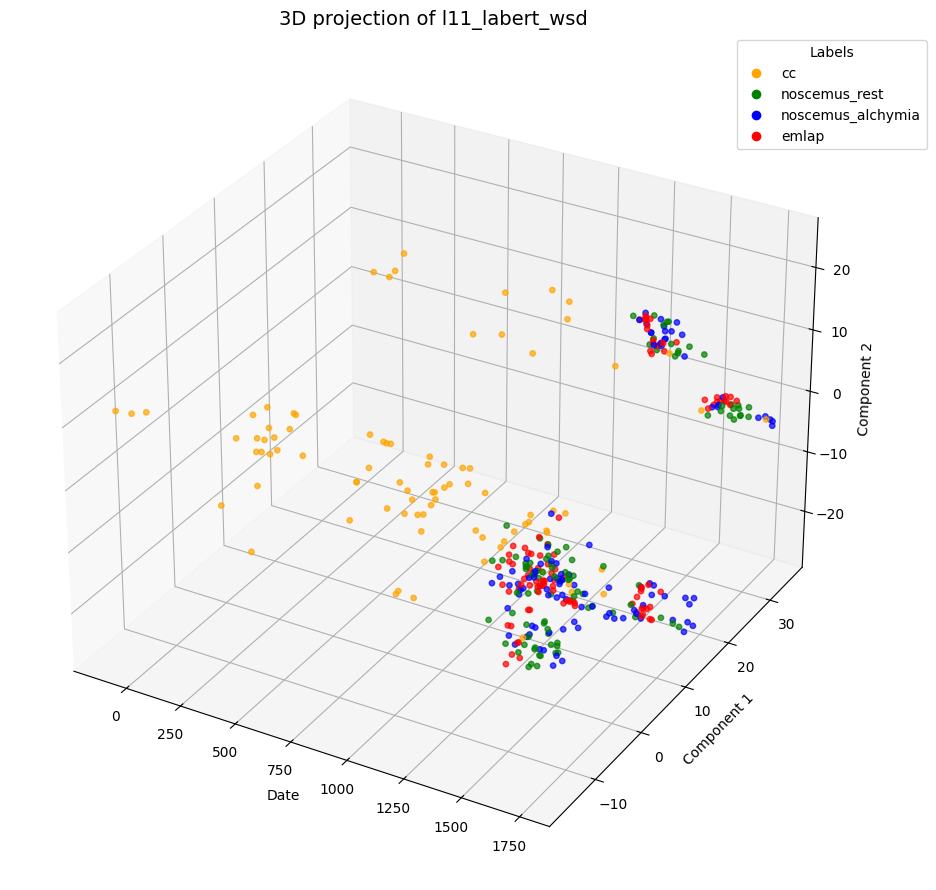

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.lines import Line2D

# Embeddings and labels
emb = np.stack(instances["embedding"])
label = "l11_labert_wsd"
xs = instances["date_random"]

ys, zs = get_2d(emb, REDUCTIONS["pca10_tsne"])
colors = instances["subsets"].map(palette)

# 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs, ys, zs, c=colors, s=15, alpha=0.7)

ax.set_title(f"3D projection of {label}", fontsize=14)
ax.set_ylabel("Component 1")
ax.set_zlabel("Component 2")
ax.set_xlabel("Date")
ax.set_xlim(min(xs) - 20, max(xs) + 20)


# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=str(lbl),
           markerfacecolor=palette[lbl], markersize=8)
    for lbl in palette.keys()
]
ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(0.85, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [244]:
import embedding_helpers

import pickle

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import os
import numpy as np
import json
import importlib
from pathlib import Path
import requests
from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer
from tensor2tensor.data_generators import text_encoder
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import umap
import tempun


import plotly.graph_objects as go
importlib.reload(embedding_helpers)
from embedding_helpers import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.lines import Line2D

outdir = Path("../data/large_files/emlap_ruland_instances/")

noscemus_alchemy_ids = pd.read_pickle("../data/noscemus_alchemy_ids.pickle")

lemma_fname_dict = dict(zip(lexeme_df["Lemma"], lexeme_df["instance_fname"]))


def read_hits(fname):
    try:
        path = os.path.join(outdir, fname)
        instances = pd.read_parquet(path).to_dict("records")
    except:
        instances = []
    instances = pd.DataFrame(instances_list)
    return instances



def get_subset(row):
    if row["grela_source"] == "noscemus":
        if row["grela_id"] in noscemus_alchemy_ids.tolist():
            return "noscemus_alchymia"
        else:
            return "noscemus_rest"
    else:
        return row["grela_source"]

def enrich_instances(instances):
    instances = instances[instances["grela_id"] != "noscemus_668514"].copy()  # exclude Ruland

    instances.loc[:, "grela_source"] = instances["grela_id"].astype(str).str.partition("_")[0]
    instances = instances[instances["grela_source"] != "vulgate"].copy()

    instances.loc[:, "subsets"] = instances.apply(get_subset, axis=1)
    instances_full_sizes_dict = instances.value_counts("subsets").to_dict()
    return instances, instances_full_sizes_dict



def produce_and_enrich_samples(instances):
    instances = (
        instances
        .sample(frac=1, random_state=42)      # shuffle rows
        .groupby("subsets", group_keys=False) # then take first up to 100 per group
        .head(100)
        .reset_index(drop=True)
    )

    # obtain random date
    instances.loc[:, "date_random"] = [
        (d[0] if isinstance(d, (list, tuple, np.ndarray)) else d)
        for d in instances.apply(
            lambda row: tempun.model_date(row["not_before"], row["not_after"]),
            axis=1
        )
    ]

    # compute embedding
    instances.loc[:, "embedding"] = instances.apply(
        lambda row: embedding_helpers.embed_emlap_instance(
            instance=row,
            tokenizer=tokenizer_labert,
            model=model_labert_wsd,
            device="cuda",
            layer_idx=11,
            piece_pooling="mean",
            context_lemmatized=True,
            target_lemmatized=True,
            context_pos_filtered=True,
        )["embedding"],
        axis=1
    )

    instances_samples_sizes_dict = instances["subsets"].value_counts().to_dict()
    return instances, instances_samples_sizes_dict

REDUCTIONS = {
    # --- UMAP variants ---
    "umap_10_0.05": lambda: umap.UMAP(n_neighbors=10, min_dist=0.05,
                                      metric="cosine", random_state=42),
    "umap_50_0.5": lambda: umap.UMAP(n_neighbors=50, min_dist=0.5,
                                     metric="cosine", random_state=42),
    "umap_100_0.8": lambda: umap.UMAP(n_neighbors=100, min_dist=0.8,
                                      metric="cosine", random_state=42),
    # --- t-SNE variants ---
    "tsne_10": lambda: TSNE(n_components=2, perplexity=10,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_30": lambda: TSNE(n_components=2, perplexity=30,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_50": lambda: TSNE(n_components=2, perplexity=50,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    # --- PCA variants ---
    "pca_std": lambda: PCA(n_components=2, whiten=False, random_state=42),
    "pca_whiten": lambda: PCA(n_components=2, whiten=True, random_state=42),
    # --- PCA→t-SNE speed trick ---
    "pca10_tsne": lambda: (
        lambda X: TSNE(n_components=2, perplexity=30,
                       init="pca", random_state=42)
        .fit_transform(PCA(n_components=10, random_state=42)
                       .fit_transform(X))
    )
}


def avg_cosine_matrix_random_pairs(
    instances,
    subset_col="subsets",
    emb_col="embedding",
    order=None,
    n_pairs=100,
    random_state=42,
    kind="distance",   # "distance" (1-cos) or "similarity" (cos)
):
    if kind not in {"distance", "similarity"}:
        raise ValueError("kind must be 'distance' or 'similarity'")

    rng = np.random.default_rng(random_state)

    if order is None:
        order = list(pd.Index(instances[subset_col].dropna().unique()).sort_values())

    # collect normalized embedding matrices per subset
    mats = {}
    for s in order:
        X = np.vstack(
            instances.loc[instances[subset_col] == s, emb_col]
            .apply(lambda v: np.asarray(v, dtype=np.float32))
            .to_numpy()
        )
        X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)  # L2 normalize
        mats[s] = X

    out = pd.DataFrame(index=order, columns=order, dtype=float)

    for i, a in enumerate(order):
        Xa = mats[a]
        na = Xa.shape[0]

        for j, b in enumerate(order):
            if j < i:
                continue

            Xb = mats[b]
            nb = Xb.shape[0]

            if na == 0 or nb == 0:
                mean_sim = np.nan

            elif a != b:
                ia = rng.integers(0, na, size=n_pairs)
                ib = rng.integers(0, nb, size=n_pairs)
                sims = np.einsum("ij,ij->i", Xa[ia], Xb[ib])  # cosine similarity
                mean_sim = float(sims.mean())

            else:
                # within-subset: pair two *different* items each time
                if na < 2:
                    mean_sim = np.nan
                else:
                    ia = rng.integers(0, na, size=n_pairs)
                    ib = rng.integers(0, na, size=n_pairs)
                    same = (ia == ib)
                    while same.any():
                        ib[same] = rng.integers(0, na, size=int(same.sum()))
                        same = (ia == ib)
                    sims = np.einsum("ij,ij->i", Xa[ia], Xa[ib])
                    mean_sim = float(sims.mean())

            val = (1.0 - mean_sim) if kind == "distance" else mean_sim
            out.loc[a, b] = val
            out.loc[b, a] = val  # symmetry

    return out

def get_2d(emb, projection):
    reducer = projection()
    if hasattr(reducer, "fit_transform"):
        embedding_2d = reducer.fit_transform(emb)
    else:  # callable expecting X directly (pca10_tsne)
        embedding_2d = reducer(emb)
    return embedding_2d[:, 0], embedding_2d[:, 1]

palette = {"cc": "orange",
           "noscemus_rest": "green",
           "noscemus_alchymia": "blue",
           "emlap": "red"
           }

labels = []
for subset in palette.keys():
    extended_label = "{0} ({1} / {2})".format(subset, instances_samples_sizes_dict.get(subset, 0), instances_full_sizes_dict.get(subset, 0))
    labels.append(extended_label)


def clean(x):
    return "" if pd.isna(x) else str(x)

def produce_hover(row):
    return "'{}' ({}, {}, [{}-{}])".format(
        clean(row.get("kwic_text")),
        clean(row.get("author")),
        clean(row.get("title")),
        clean(row.get("not_before")),
        clean(row.get("not_after")),
    )
# ------------------------------------------------------------------

# Embeddings and labels
def make_plot(instances, palette, instances_full_sizes_dict, instances_samples_sizes_dict, projection, form):
    instances["hover"] = instances.apply(lambda row: produce_hover(row), axis=1)
    hovers = instances["hover"]
    labels = []
    for subset in palette.keys():
        extended_label = "{0} ({1} / {2})".format(subset, instances_samples_sizes_dict.get(subset, 0), instances_full_sizes_dict.get(subset, 0))
        labels.append(extended_label)
    emb = np.stack(instances["embedding"])
    label = "l11_labert_wsd"
    xs = instances["date_random"]
    ys, zs = get_2d(emb, REDUCTIONS[projection])
    colors = instances["subsets"].map(palette)
    if form == "static":
    # 3D scatter plot
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xs, ys, zs, c=colors, s=15, alpha=0.7)

        ax.set_title(f"3D projection of {label}", fontsize=14)
        ax.set_ylabel("Component 1")
        ax.set_zlabel("Component 2")
        ax.set_xlabel("Date")
        ax.set_xlim(min(xs) - 20, max(xs) + 20)

        # Legend
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label=str(lbl),
                   markerfacecolor=color, markersize=8) for lbl, color in zip(labels, palette.values())
        ]
        ax.legend(handles=legend_elements, title="Subsets (sample / full)", bbox_to_anchor=(0.85, 1), loc='upper left')

        plt.tight_layout()
        return fig
    else:
        fig = go.Figure(
        data=[
            go.Scatter3d(
                x=xs,
                y=ys,
                z=zs,
                mode="markers",
                marker=dict(size=4, opacity=0.7, color=colors),
                text=instances["hover"],
                hovertemplate="%{text}<extra></extra>",
            )
        ]
        )

        fig.update_layout(
            title=f"3D projection of {label}",
            scene=dict(
                xaxis_title="Date",
                yaxis_title="Projected dimension Y",
                zaxis_title="Projected dimension Z",
            ),
            margin=dict(l=0, r=0, b=0, t=40),
        )

        return fig

def from_lemma_to_plot(lemma, projection, form):
    fname = lemma_fname_dict[lemma]
    instances_full = read_hits(fname)
    instances_full, instances_full_sizes_dict = enrich_instances(instances_full)
    instances_sample, instances_samples_sizes_dict = produce_and_enrich_samples(instances_full)
    S = avg_cosine_matrix_random_pairs(instances_sample, order=["emlap","noscemus_alchymia","noscemus_rest","cc"],
                                   n_pairs=100, kind="similarity")
    fig = make_plot(instances_sample, palette, instances_full_sizes_dict, instances_samples_sizes_dict, projection, form)
    return fig, fname, instances_sample, S, instances_full_sizes_dict, instances_samples_sizes_dict

In [245]:
fig, fname, instances_sample, S, instances_full_sizes_dict, instances_samples_sizes_dict = from_lemma_to_plot("Lapis philosophorum", projection="tsne_30",form="dynamic")

In [246]:
fig

In [163]:
lemma_fname_dict = dict(zip(lexeme_df["Lemma"], lexeme_df["instance_fname"]))

/tmp/ipykernel_292755/1244341653.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instances["subsets"] = instances.apply(lambda row: get_subset(row), axis=1)
/tmp/ipykernel_292755/1244341653.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(100, len(g)), random_state=42))


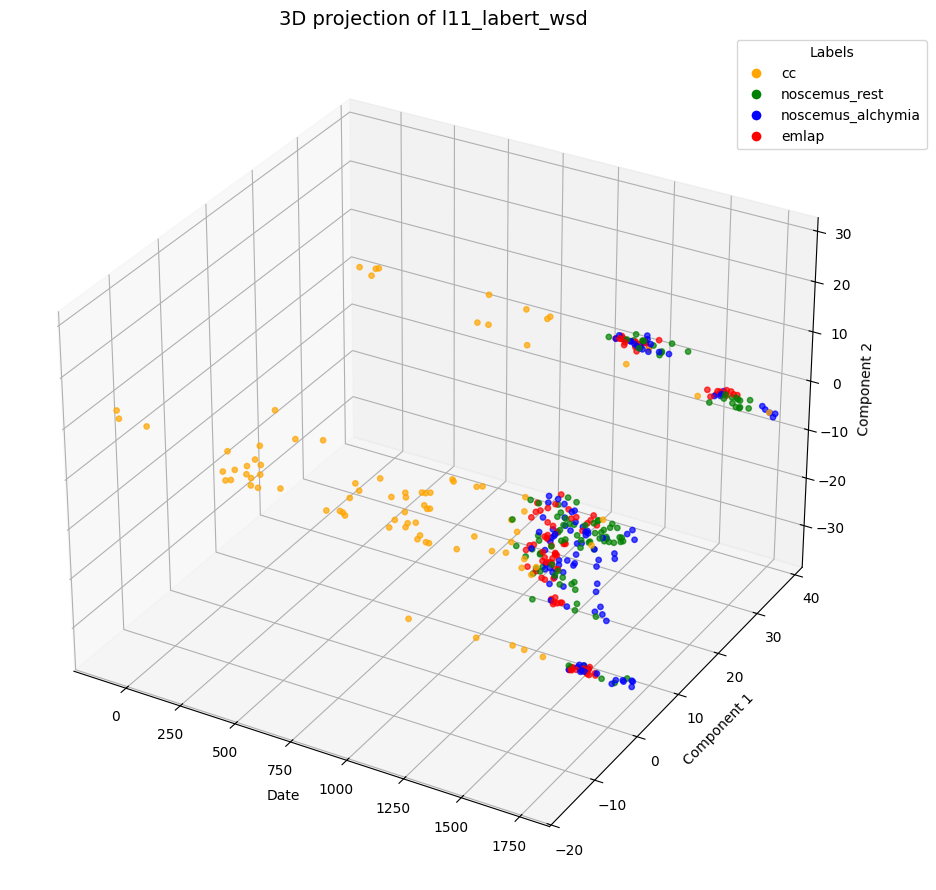

In [159]:
fig, instances_sample,  instances_full_sizes_dict, instances_samples_sizes_dict = from_fname_to_plot("aurum.parquet")